## 1.导入包

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import re
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.inf)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
"""
网格搜索(Grid Search)和Optuna，找到模型的最佳超参数组合
网格搜索适用于超参数空间较小、离散且较少的情况，而Optuna适用于超参数空间较大、连续或离散且较多的情况
下面要做的事情：
1.换新的面心值标签，现在数据过拟合，训练集下降但是测试集上升或者波动
2.考虑正则化或者假如droput层来防止过拟合
3.考虑数据预处理中采用数据标准化，让数据均匀分布
4.用不用考虑损失函数，学习率,epoch,adam优化器及其四个参数，的修改，模型用不用再添加几层让模型变复杂些（batch-size越大，训练越快，不影响准确率）
5.早停法（Early Stopping）：在训练过程中监控验证集上的性能，一旦性能停止改善，在一定epoch后停止训练，并保存模型，以防止过拟合。可以参照外国那案例
6.数据集的比例，不一定4：1，也可以95：5，当数据集足够大时，这样可以增加训练集数量
"""

'\n网格搜索(Grid Search)和Optuna，找到模型的最佳超参数组合\n网格搜索适用于超参数空间较小、离散且较少的情况，而Optuna适用于超参数空间较大、连续或离散且较多的情况\n下面要做的事情：\n1.换新的面心值标签，现在数据过拟合，训练集下降但是测试集上升或者波动\n2.考虑正则化或者假如droput层来防止过拟合\n3.考虑数据预处理中采用数据标准化，让数据均匀分布\n4.用不用考虑损失函数，学习率,epoch,adam优化器及其四个参数，的修改，模型用不用再添加几层让模型变复杂些（batch-size越大，训练越快，不影响准确率）\n5.早停法（Early Stopping）：在训练过程中监控验证集上的性能，一旦性能停止改善，在一定epoch后停止训练，并保存模型，以防止过拟合。可以参照外国那案例\n6.数据集的比例，不一定4：1，也可以95：5，当数据集足够大时，这样可以增加训练集数量\n'

## 2.加载数据

"""
1.功能：
通过加载data和label文件，然后继续训练和预测。
定义了一个6层卷积神经网络模型。每个卷积层后面跟着一个 ReLU 激活函数。第七层只有卷积，没有relu。
输入数据n*64*64*2,这里的一个样本64*64可以看成一个图片格式（在此次任务中是速度，两者类似）
输出是n*64*64*4
"""
"""txt保存为numpy格式发现可以减少存储大小，约缩小成1/4
5.9G	./all_data.npy
12G	./all_label.npy
27G	./data_64x64x2.txt
53G	./label_a_2x64x65x2.txt
"""

In [3]:
# 直接加载npy文件为numpy格式
all_data = np.load('./data/all_data.npy')
# #直接加载npy文件为numpy格式,注意标签是面心值，不是a值
all_label = np.load('./data/all_centerFace_label.npy')

all_data = torch.tensor(all_data).float()
all_label = torch.tensor(all_label).float()


## 3.构建模型

In [4]:

#神经网络模型
class Net(nn.Module):
    def __init__(self, num_output_channels):
        super(Net, self).__init__()

        # 第一层卷积，使用64个大小为3x3的卷积核，输入数据的shape为2x64x64，使用ReLU激活函数。
        # 输入通道数为2，输出通道数恒为64
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()

        # 第二层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        # 第三层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        # 第四层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()

        # 第五层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()

        # 第六层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu6 = nn.ReLU()

        # 第七层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数,输出数据为4*64*64
        # 输入通道数为64，输出通道数恒为4
        self.conv7 = nn.Conv2d(64, num_output_channels, kernel_size=3, stride=1, padding=1)



    def forward(self, x):
        x = self.conv1(x)  # x:torch.Size([10, 2, 64, 64])
        x = self.relu1(x)

        x = self.conv2(x)  # x:torch.Size([10, 64, 64, 64])
        x = self.relu2(x)

        x = self.conv3(x)  # x:  torch.Size([10, 64, 64, 64])
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.relu4(x)

        x = self.conv5(x)
        x = self.relu5(x)

        x = self.conv6(x)
        x = self.relu6(x)

        x = self.conv7(x)

        # 输出数据shape: torch.Size([10, 4, 64, 64]),10是batch_size大小
        return x



## 4.模型训练与测试

In [5]:
def train(num_output_channels):
    
    import time
    start_time = time.time()

    # 定义一个batch包含的样本数目
    batch_size =128

    # 生成数据集
    x_train, x_test, y_train, y_test = train_test_split(all_data, all_label, test_size=0.2)

    # 设置种子数
    seed = 42
    torch.manual_seed(seed)

    # 划分数据集
    trainset = torch.utils.data.TensorDataset(x_train, y_train)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True)

    # 划分数据集
    testset = torch.utils.data.TensorDataset(x_test, y_test)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=True)


    # 创建模型实例，并将模型移动到GPU设备上进行计算
    net = Net(num_output_channels).to(device)
    
    # 加速训练：如果有多个GPU，则使用DataParallel模块
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
        print("采用DataParallel加速，device_count个数为：",str(torch.cuda.device_count()))
        
    # 定义损失函数为均方误差
    criterion = nn.MSELoss()  # 将预测值与真实标签之间的差值求平方和，再除以样本数n来得到平均损失值

    # 定义优化器为Adam优化器,设置学习率为0.001
    optimizer = optim.Adam(net.parameters(),lr = 0.001)

    print('begin to train!!!')

    # 训练模型
    num_epochs = 100  # 训练轮数
    train_loss = []
    test_loss = []
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            # 将参数的梯度设为0
            optimizer.zero_grad()

            # 前向传播+后向传播+优化
            outputs = net(inputs)
            # inputs:torch.Size([10, 2, 64, 64])
            # outputs:torch.Size([10, 4, 64, 64])
            """
            criterion：表示所选的损失函数，这里选择的是MSE均方误差
            outputs：模型在输入后得到的输出，它的形状是(batch_size, num_output_channels, height, width)
            """
            loss = criterion(outputs, labels)  # labels   :torch.Size([10, 120, 64, 64])
            loss.backward()  # 有了损失值后，就可以根据反向传播算法来更新模型参数，使得预测值更接近真实标签。
            optimizer.step()

            # 统计损失值
            running_train_loss += loss.item()  # 在训练过程中，目标就是通过反向传播和优化算法尽可能地减小该损失值，提高模型的性能。
            
                        # 每20个batch打印一次平均损失值，这里batch-size=10,相当于每100个样本打印一次loss
#             if i % 20 == 19:
#                 print('[epoch:  %d, batch:%5d] train loss: %.3f' %
#                       (epoch + 1, i + 1, running_train_loss))
        print("running_train_loss:",running_train_loss)        
        train_loss.append(running_train_loss)
            

                
        running_test_loss = 0.0
        for i, (inputs, labels) in enumerate(testloader):
            inputs, labels = inputs.to(device), labels.to(device)
            # 前向传播(预测)+后向传播+优化
            outputs = net(inputs)
            # inputs:torch.Size([10, 2, 64, 64])
            # outputs:torch.Size([10, 4, 64, 64])
            """
            criterion：表示所选的损失函数，这里选择的是MSE均方误差
            outputs：模型在输入后得到的输出，它的形状是(batch_size, num_output_channels, height, width)
            """
            loss = criterion(outputs, labels)  # labels   :torch.Size([10, 120, 64, 64])

            # 统计损失值
            running_test_loss += loss.item()  # 在训练过程中，目标就是通过反向传播和优化算法尽可能地减小该损失值，提高模型的性能。
            
        print("running_test_loss:",running_test_loss)        
        test_loss.append(running_test_loss)
        print("已完成第：",str(epoch+1),"个epoch!")


    end_time = time.time()
    process_time = end_time - start_time
    print(f"模型训练和测试共用了: {process_time} 秒！")#预处理data用了: 705.8258590698242 秒！
    print('all of tasks Finished')
    
    # 保存整个模型
    torch.save(net, './model/model_origin_100_01.pth')
    
    return train_loss,test_loss


"""
已完成第： 60 个epoch!
模型训练和测试共用了: 2325.386168241501 秒！
"""
train_loss,test_loss  = train(num_output_channels=4)
print(train_loss)
print(test_loss)
# 将数据写入文件，格式只能为二进制,二进制数据无法查看，想查看的话可以将其写入到txt里面或者用deebug查看
np.save('./data/lossa/loss_model_100_01.npy', np.array([train_loss,test_loss]))

采用DataParallel加速，device_count个数为： 4
begin to train!!!
running_train_loss: 2538.7948174476624
running_test_loss: 606.7607861757278
已完成第： 1 个epoch!
running_train_loss: 2404.6842716932297
running_test_loss: 599.2399100065231
已完成第： 2 个epoch!
running_train_loss: 2379.895949602127
running_test_loss: 592.6978417634964
已完成第： 3 个epoch!
running_train_loss: 2360.048185944557
running_test_loss: 590.5456990003586
已完成第： 4 个epoch!
running_train_loss: 2341.3683822155
running_test_loss: 583.7338837385178
已完成第： 5 个epoch!
running_train_loss: 2321.8513003587723
running_test_loss: 578.2130388021469
已完成第： 6 个epoch!
running_train_loss: 2303.9293974637985
running_test_loss: 575.7247251272202
已完成第： 7 个epoch!
running_train_loss: 2287.2971588373184
running_test_loss: 571.0661680698395
已完成第： 8 个epoch!
running_train_loss: 2271.563721060753
running_test_loss: 565.9621993303299
已完成第： 9 个epoch!
running_train_loss: 2256.7125936746597
running_test_loss: 563.6782562732697
已完成第： 10 个epoch!
running_train_loss: 2244.128722

running_test_loss: 511.3177442550659
已完成第： 89 个epoch!
running_train_loss: 2021.7164919376373
running_test_loss: 508.92739248275757
已完成第： 90 个epoch!
running_train_loss: 2021.6412892341614
running_test_loss: 515.1121616363525
已完成第： 91 个epoch!
running_train_loss: 2020.440907239914
running_test_loss: 511.7580506801605
已完成第： 92 个epoch!
running_train_loss: 2020.7340586185455
running_test_loss: 504.7444304227829
已完成第： 93 个epoch!
running_train_loss: 2017.5416647195816
running_test_loss: 508.73788368701935
已完成第： 94 个epoch!
running_train_loss: 2016.8048303127289
running_test_loss: 506.5000147819519
已完成第： 95 个epoch!
running_train_loss: 2017.4914021492004
running_test_loss: 507.6609740257263
已完成第： 96 个epoch!
running_train_loss: 2017.132085442543
running_test_loss: 507.0704548358917
已完成第： 97 个epoch!
running_train_loss: 2014.824568271637
running_test_loss: 507.27767050266266
已完成第： 98 个epoch!
running_train_loss: 2013.216926932335
running_test_loss: 509.52987468242645
已完成第： 99 个epoch!
running_train_lo

In [6]:
print(all_data.shape)
print(all_label.shape)


torch.Size([192000, 2, 64, 64])
torch.Size([192000, 4, 64, 64])


In [7]:
train_loss,test_loss = np.load('./data/lossa/loss_model_100.npy')
print(train_loss)

[2538.79481745 2404.68427169 2379.8959496  2360.04818594 2341.36838222
 2321.85130036 2303.92939746 2287.29715884 2271.56372106 2256.71259367
 2244.12872279 2231.51688075 2219.80078459 2212.62686074 2202.40908289
 2192.85854948 2184.78709686 2178.91341996 2169.99986899 2166.47633207
 2159.97113347 2153.56419051 2148.69560409 2143.48951805 2139.64367032
 2135.13824451 2131.89319384 2127.94826019 2123.03915417 2120.06264877
 2117.30794263 2113.86053634 2111.77120864 2106.01497829 2104.45798349
 2102.91278374 2099.20727444 2097.1886394  2094.63565683 2092.25586939
 2089.92465603 2087.04373538 2083.40431654 2083.54514194 2080.58037329
 2079.13215733 2076.53758252 2074.61912358 2072.95081615 2070.20391798
 2068.67251945 2067.10390925 2064.57589519 2063.24101579 2062.13906562
 2059.85878277 2059.67278326 2057.08519042 2056.79482615 2054.29027069
 2052.3082968  2051.52948034 2050.63563097 2049.61985195 2047.56832016
 2046.26841605 2045.91378486 2044.48175848 2043.40380299 2042.75548732
 2040.

# 5.可视化loss

[0.01652, 0.01565, 0.01549, 0.01536, 0.01524, 0.01511, 0.01499, 0.01489, 0.01479, 0.01469, 0.01461, 0.01452, 0.01445, 0.0144, 0.01434, 0.01427, 0.01422, 0.01418, 0.01412, 0.0141, 0.01406, 0.01402, 0.01398, 0.01395, 0.01393, 0.0139, 0.01387, 0.01385, 0.01382, 0.0138, 0.01378, 0.01376, 0.01374, 0.01371, 0.0137, 0.01368, 0.01367, 0.01365, 0.01363, 0.01362, 0.0136, 0.01359, 0.01356, 0.01356, 0.01354, 0.01354, 0.01352, 0.0135, 0.01349, 0.01348, 0.01346, 0.01346, 0.01344, 0.01343, 0.01342, 0.0134, 0.0134, 0.01339, 0.01339, 0.01337, 0.01336, 0.01335, 0.01335, 0.01334, 0.01333, 0.01332, 0.01331, 0.01331, 0.0133, 0.01329, 0.01328, 0.01327, 0.01327, 0.01326, 0.01326, 0.01325, 0.01324, 0.01324, 0.01322, 0.01322, 0.01322, 0.01321, 0.0132, 0.01319, 0.01319, 0.01318, 0.01318, 0.01317, 0.01316, 0.01316, 0.01316, 0.01315, 0.01315, 0.01313, 0.01312, 0.01313, 0.01313, 0.01311, 0.01311, 0.01312]


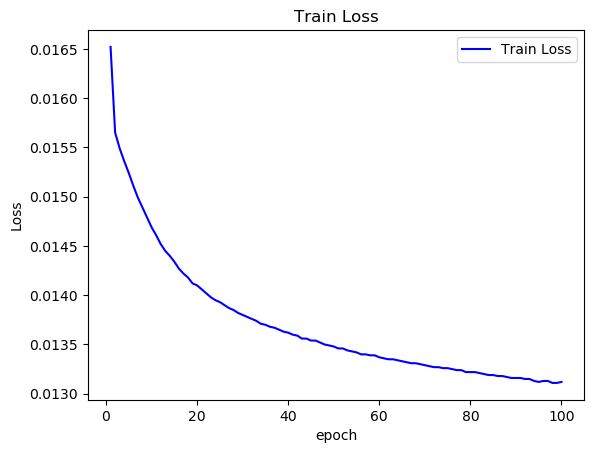

In [8]:
import matplotlib.pyplot as plt
# 创建 x 轴数据，假设为 epoch 数
epoch = np.arange(1, len(train_loss) + 1)

train_loss = [round(int(a)/(all_data.shape[0]*0.8), 5) for a in train_loss]
print(train_loss)
# 绘制训练损失曲线
plt.plot(epoch, train_loss, 'b', label='Train Loss')

# 关闭科学计数法
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)

# 设置y轴范围下限为0
# plt.ylim(bottom=0)

# 设置图表标题和轴标签
plt.title('Train Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')

# 添加图例
plt.legend()

# 显示图表
plt.show()

[606.76078618 599.23991001 592.69784176 590.545699   583.73388374
 578.2130388  575.72472513 571.06616807 565.96219933 563.67825627
 560.47908342 558.34579957 556.42140031 552.86192274 550.97598267
 550.04952168 546.59051406 545.40527236 543.94176328 543.61749971
 541.39596438 539.62406039 544.19162571 537.2791276  536.59659815
 533.68663967 533.02022743 533.95463967 534.90985334 532.85544991
 530.30101383 530.70179725 528.987396   532.88671231 528.54571462
 528.47866595 528.80580783 525.1746105  526.61265469 526.57214332
 524.73279834 524.52644253 524.65573335 523.05072165 521.50164163
 522.40610588 521.88383174 522.73738396 521.34493923 520.01745152
 520.17815042 519.38368821 518.58522594 517.87056518 519.21798384
 516.55514157 518.28245187 516.74786818 516.84865654 514.4573108
 515.80296373 514.76108205 516.14496338 517.35066044 515.77127314
 515.34642804 515.84728134 513.54722619 515.86405981 512.25905752
 513.22478867 513.99726701 512.99024665 513.61540949 512.06592262
 510.594652

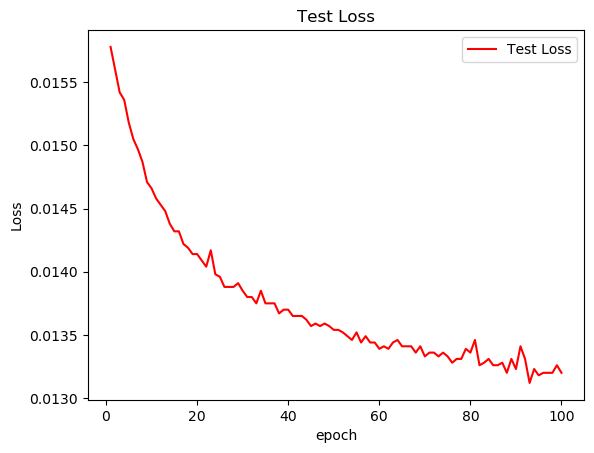

In [9]:
# 创建 x 轴数据，假设为 epoch 数
epoch = np.arange(1, len(test_loss) + 1)
print(test_loss)
test_loss = [round(int(a)/(all_data.shape[0]*0.2), 5) for a in test_loss]


# 绘制测试损失曲线
plt.plot(epoch, test_loss, 'r', label='Test Loss')

# 设置图表标题和轴标签
plt.title('Test Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')

# 添加图例
plt.legend()

# 显示图表
plt.show()

In [10]:
# from torchsummary import summary
# # 将模型移动到适当的设备
# model = model.to(device)

# # 打印模型的概要信息
# summary(model,input_size=(2, 64, 64))

## 6.预测

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 加载模型
model = torch.load('./model/model_origin_100.pth', map_location=device)# from torchsummary import summary
# # 将模型移动到适当的设备

model = model.to(device)


In [29]:
# 设置模型为评估模式
model.eval()

# 输入数据进行预测
input_data =all_data[0]  # 你的输入数据


#调整输入input的维度顺序,作为E，用于下面change_Label_to_a中(E-A)/(B-A)得到a值
matrix_64 = all_data[0].cpu()
matrix_64 = matrix_64.permute(1,2,0)  
print(matrix_64.shape)


# 转换为四维
input_data = input_data.unsqueeze(0)#用实际数据，数据格式为(1,2, 64, 64)，不能为2x64x64
# input_data = torch.randn(1,2, 64, 64)
print(input_data.shape)
input_tensor = input_data.to(device)

with torch.no_grad():
    output = model(input_tensor)##如果报错的话需要把网络的设计加上，里面涉及model(input)

# 打印预测结果
print(output)

torch.Size([64, 64, 2])
torch.Size([1, 2, 64, 64])
tensor([[[[-3.3691, -3.9916, -3.9690,  ..., -3.4525, -3.5089, -3.1295],
          [-3.6142, -3.5814, -3.9007,  ..., -3.2416, -3.3050, -3.2170],
          [-3.2902, -3.0554, -3.4440,  ..., -3.5078, -3.2206, -3.1546],
          ...,
          [-3.7948, -3.9085, -3.5546,  ..., -3.2850, -3.6687, -3.9976],
          [-3.9078, -3.8390, -3.4189,  ..., -3.3689, -3.7248, -3.9864],
          [-3.5135, -3.5176, -3.4608,  ..., -3.5942, -3.6344, -3.2458]],

         [[ 2.5954,  2.6313,  2.8728,  ...,  3.6375,  3.6245,  3.0684],
          [ 3.1124,  2.8411,  2.9023,  ...,  3.7276,  3.9283,  3.4171],
          [ 2.9566,  2.7564,  2.7111,  ...,  3.8368,  3.6636,  3.2174],
          ...,
          [ 2.8406,  2.3748,  1.9444,  ...,  2.9727,  2.7759,  3.0495],
          [ 3.2612,  2.7748,  2.1713,  ...,  2.9377,  2.9729,  3.0661],
          [ 3.1281,  2.9447,  2.4087,  ...,  3.3320,  3.4262,  2.9596]],

         [[-3.4965, -2.8207, -2.6931,  ..., -3.4822

/tmp/ipykernel_2419029/2034565812.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_data).to(device)


# 8.转换格式(label转为最终的weights)

In [30]:
#将label面心值转为a值
def change_Label_to_a(all_vertical_edge_centers,all_horizontal_edge_centers):
    a_vertical = np.zeros((64, 65, 2))
    # a_vertical = np.random((64, 65, 2))
    a_horizontal = np.zeros((64, 65, 2))
    # a_horizontal = np.random.random((64, 65, 2))


    # 21. 求a:   横着的边，分两种情况，边缘（对称的）和非边缘的边.这里matrix_64要行列互换，因为横着时面心值是一列一列求得，竖着时是一行一行求的。
    for i in range(64):
        for j in range(65):
            if j == 0 or j == 64:
                # a_horizontal[i, j] = (all_horizontal_edge_centers[i, 0] - matrix_64[i, 0]) / (matrix_64[i, 63] - matrix_64[i, 0])#换之前
                a_horizontal[i, j] = (all_horizontal_edge_centers[i, 0] - matrix_64[0, i]) / (
                    matrix_64[63, i] - matrix_64[0, i])
            else:
                # aA=(1-a)B=E   a = (E-B)/(A-B) 其中：A为matrix_64[i,j]，B为matrix_64[i,j+1]
                # a_horizontal[i, j] = (all_horizontal_edge_centers[i, j] - matrix_64[i, j]) / (matrix_64[i, j-1] - matrix_64[i, j])
                a_horizontal[i, j] = (all_horizontal_edge_centers[i, j] - matrix_64[j, i]) / (
                    matrix_64[j - 1, i] - matrix_64[j, i])

    # 22. 求a:   竖着的边，分两种情况，边缘（对称的）和非边缘的边
    for i in range(64):
        for j in range(65):
            if j == 0 or j == 64:
                a_vertical[i, j] = (all_vertical_edge_centers[i, 0] - matrix_64[i, 0]) / (
                    matrix_64[i, 63] - matrix_64[i, 0])
            else:
                # aA=(1-a)B=E   a = (E-B)/(A-B) 其中：A为matrix_64[i,j]，B为matrix_64[i,j+1]
                # 2.错误matrix_64[i, j-1]) / (改成matrix_64[i, j]) / (
                a_vertical[i, j] = (all_vertical_edge_centers[i, j] - matrix_64[i, j]) / (
                    matrix_64[i, j - 1] - matrix_64[i, j])

    # # 若最终a对应的矩阵里面出现无穷，则将其替换为0.5.解决了分母为0的问题
    # a_vertical[np.isinf(a_vertical)] = 0.5
    # a_horizontal[np.isinf(a_horizontal)] = 0.5
    #这里64x65x2截成64x64x2,因为边框对称时值相同
    
    a_vertical = torch.tensor(a_vertical[:,:64,:])
    a_horizontal = torch.tensor(a_horizontal[:,:64,:])

    print(a_vertical.shape)
    print(a_horizontal.shape)
    return  a_vertical,a_horizontal

In [31]:
#返回一个列表，里面嵌套两个子列表，第一个子列表存放的是内部的a值，第二个子列表存放的是边框的a值，
#且顺序为上（左到右），下（左到右），左（下到上），右（下到上）
def conversion_format(output):
    # 调整output的维度顺序
    output = output.permute(0,2,3,1)  
    print(output.shape)
    output = output[0]
    print(output.shape)
    # print(output)

    #将输出output拆成两个面心值
    all_vertical_edge_centers = output[:, :, 0:2].cpu()
    all_horizontal_edge_centers = output[:, :, 2:4].cpu()
    print(all_vertical_edge_centers.shape)
    print(all_horizontal_edge_centers.shape)

    
    a_vertical,a_horizontal  = change_Label_to_a(all_vertical_edge_centers,all_horizontal_edge_centers)    
    
    # 将前两个元素相加除以二得到一个元素(x+y/)2
    avg_vertical = (a_vertical[:, :, 0] + a_vertical[:, :, 1]) / 2
    # 将后两个元素相加除以二得到另一个元素
    avg_horizontal = (a_horizontal[:, :, 0] + a_horizontal[:, :, 1]) / 2

    # 重新组合成新的形状为(64, 64, 2)的张量
    new_avg_a_output = torch.stack([avg_vertical, avg_horizontal], dim=2)
    # 打印转换后的数据形状
    print(new_avg_a_output.shape)

    #返回两个求完平均的面心值,包括两个64*64矩阵，矩阵是求完平均后的a值，一个竖着的，一个横着的
    vertical_1d = new_avg_a_output[:, :, 0]
    horizontal_1d = new_avg_a_output[:, :,1]
    print(vertical_1d.shape)
    print(horizontal_1d.shape)
    
    
    border = []#存所有边框，四个边框
    left_border=[]#存左边框
    bottom_border = []#存下边框
    inner = []#存内部的面心值

    #下面将2个64x64面心值变换格式，返回指定的格式result
    for i in range(len(vertical_1d)): #两个for循环等价于for i in range(64):
        for j in range(len(vertical_1d[i])):
            if j ==0:#j=0添加边框
                #添加左边框
                left_border.append(vertical_1d[i][0])
                #添加下边框
                bottom_border.append(horizontal_1d[i][0])
            else: 
                if i !=  63:#当竖着的最后一行时，上面没有对应的横着的
                    inner.append(vertical_1d[i][j])#竖着的
    #                 print("{j-1},{i+1}",j-1,i+1)
                    inner.append(horizontal_1d[j-1][i+1])   #再横着的   
                    if j == 63:#如果j=63的话，还需要再加入最后一列的横着的边
                        inner.append(horizontal_1d[63][i+1])#当i=63,横着的加最后一列 
                else:#if i ==63 :
                    inner.append(vertical_1d[63][j])#当i=63,inner最后添加竖着的一行竖线

    inner = [tensor.cpu().numpy() for tensor in inner]#将一维列表里面的tensor元素转为numpy格式，并返回cpu版本
    # print(inner)
    four_border = [bottom_border,bottom_border,left_border,left_border]#顺序是上（左到右），下（左到右），左（下到上），右（下到上）
    border = [item for sublist in four_border for item in sublist]
    result = [inner,border]
    print(len(result))
    return result



In [32]:
result  = conversion_format(output)

torch.Size([1, 64, 64, 4])
torch.Size([64, 64, 4])
torch.Size([64, 64, 2])
torch.Size([64, 64, 2])
torch.Size([64, 64, 2])
torch.Size([64, 64, 2])
torch.Size([64, 64, 2])
torch.Size([64, 64])
torch.Size([64, 64])
2


In [39]:
print(len(result[0]))
print(len(result[1]))
print(8064+64*2)

8064
256
8192
